# Evaluation of all the models to detect defects in steel sheet 

### 1. Requirments

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import sys
import os
import time
import cv2
import torch

sys.path.append('\\'.join(os.getcwd().split('\\')[:-1])+'\\src')
import utils as c_utils
import dataset as c_dataset
import models as c_models

from tqdm import tqdm
from torchvision import models
from torch import nn
from sklearn.metrics import (f1_score, 
                             accuracy_score, 
                             balanced_accuracy_score, 
                             confusion_matrix, 
                             roc_curve, 
                             auc, 
                             recall_score, 
                             precision_score)

In [3]:
device = torch.device('cuda')
vgg16 = models.vgg16_bn(pretrained=True)
vgg16.avgpool = nn.Flatten()
vgg16.classifier = nn.Sequential(nn.Linear(in_features=12288, out_features=256, bias=True),
                                 nn.ReLU(inplace=True),
                                 nn.Dropout(p=0.5, inplace=False),
                                 nn.Linear(in_features=256, out_features=32, bias=True),
                                 nn.ReLU(inplace=True),
                                 nn.Dropout(p=0.5, inplace=False),
                                 nn.Linear(in_features=32, out_features=6, bias=True))
net = vgg16.to(device)

In [5]:
#net = c_utils.vgg_load_state_dict(net, '../model/MultiAugmentedVGG.json')
torch.save(net.state_dict(), '../model/OfficialMultiModels/MultiAugmentedVGG.pth')

### 2. Parameters

In [23]:
MODEL_PATHS = ['../model/OfficialMultiModels/MultiUltraVanillaSqueeze.pth',
               '../model/OfficialMultiModels/MultiUltraVanillaVGG.pth',
               '../model/OfficialMultiModels/MultiCNN.pth',
               '../model/OfficialMultiModels/MultiWeightedSqueeze.pth',
               '../model/OfficialMultiModels/MultiAugmentedVGG.pth',
               '../model/OfficialMultiModels/MultiAugmentedSqueezeReduced.pth',
               '../model/OfficialMultiModels/MultiAugmentedCNN.pth',
               '../model/OfficialMultiModels/MultiSlidedSqueezeReduced10.pth',
               '../model/OfficialMultiModels/MultiSqueeze.pth',
               #'../model/MultiVanillaSlidedSqueeze.pth',
               #'../model/MultiVanillaSlidedWeightedSqueeze.pth',
               #'../model/OfficialMultiModels/MultiSqueeze.pth',
               #'../model/OfficialMultiModels/MultiVanillaSqueeze.pth',
               #'../model/OfficialMultiModels/MultiSqueezeReduced.pth',
               #'../model/OfficialMultiModels/MultiWeightedSqueezeReduced.pth',
               #'../model/OfficialMultiModels/MultiAugmentedSqueeze.pth',
               #'../model/MultiAugmentedSqueezeReduced10B.pth',
               #'../model/MultiAugmentedSqueezeReduced8.pth',
               #'../model/MultiUltraVanillaVGG.pth',
               
               '../model/OfficialMultiModels/MultiVanillaVGG.pth'
              ]

IMAGE_PATH = '../data/train_images'
DATA_PATH = '../data/multiData'
METADATA_PATH = '../data/multiData/test_data.csv'

INPUT_PATH = DATA_PATH + '/' + 'X_test.pth' 
LABEL_PATH = DATA_PATH + '/' + 'y_test.pth'
MASK_PATH  = DATA_PATH + '/' + 'M_test.pth'

In [24]:
N_CLASSES = 5
N_MODEL = len(MODEL_PATHS)
params = c_utils.get_default_params()
device = torch.device('cuda')
params

{'size': (64, 400),
 'mask_size': (64, 400),
 'mean': [0.485, 0.456, 0.406],
 'std': [0.229, 0.224, 0.225],
 'colors': [[0, 0.25, 0.25],
  [0.25, 0.0, 0.0],
  [0.0, 0.25, 0.0],
  [0.0, 0.0, 0.25]]}

### 3. Data
#### 3.1 Load data
Since retrieving all the batches using dataloader has been quite slow and created problem in Colab, a procedure to generate the full torch matrix (input, labels and masks) from the images should be performed to run this jupyter smoothly. If the INPUT, MASK and LABEL matrix are already present in the given paths we just load them


In [25]:
### Check if the given paths exists
if DATA_PATH.split('/')[1] not in os.listdir(DATA_PATH.split('/')[0]): # Create folder if it does not exists
    os.mkdir(DATA_PATH) 
c1 = INPUT_PATH.split('/')[-1] in os.listdir(DATA_PATH)
c2 = LABEL_PATH.split('/')[-1] in os.listdir(DATA_PATH)
c3 = MASK_PATH.split('/')[-1] in os.listdir(DATA_PATH)

In [26]:
### If the path are present we load the matrix, else we generate them
if c1 and c2 and c3:
    print('Data is present and ready to be loaded')
    X_val, y_val, M_val = torch.load(INPUT_PATH), torch.load(LABEL_PATH), torch.load(MASK_PATH)
else:
    print('Starting process to create matrices...')
    time.sleep(0.1)
    X_val, y_val, M_val = c_utils.create_data(IMAGE_PATH, METADATA_PATH, 
                                              batch_size=200, num_workers=0, 
                                              return_mask=True, params=params)

Data is present and ready to be loaded


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


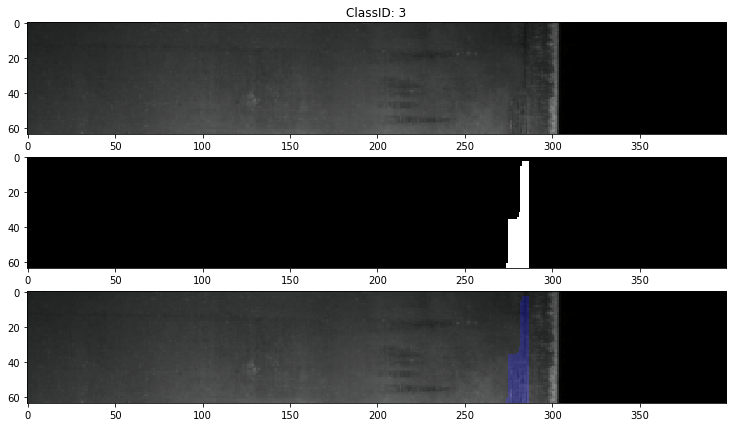

In [27]:
#### 3.2 Visualize data

n = 1

fig, ax = plt.subplots(3, 1, figsize=(20, 7))
img = np.transpose(X_val[n].numpy(), (1, 2, 0))*params['std'] + params['mean']
mask = M_val[n].reshape(*params['size'])
ax[0].set_title('ClassID: {}'.format(y_val[n]))
ax[0].imshow(img)
ax[1].imshow(mask, cmap='gray')
img[mask == 1] = img[mask == 1] + params['colors'][y_val[n]]
ax[2].imshow(img)
plt.show()

### 4. Model

    a) Load SqueezeNet architecture
    b) Modify the classifier architecture for each model
    c) Load the parameters
    d) Move model in GPU

In [28]:
### 4.1 Load architecture
nets = []
for MODEL_PATH in MODEL_PATHS:
    if 'Squeeze' in MODEL_PATH:
        net = models.squeezenet1_1(pretrained=True)
        if 'Reduced8' in MODEL_PATH:
            net.features = net.features[:8]
            net.classifier[1] = nn.Conv2d(256, 1000, kernel_size = (1, 1), stride = (1, 1))
            net.classifier = nn.Sequential(*net.classifier, nn.Flatten(), nn.Linear(1000, N_CLASSES))#, nn.Softmax(dim=1))
        elif 'Reduced10B' in MODEL_PATH:
            net.features = net.features[:10]
            net.classifier[1] = nn.Conv2d(384, 1000, kernel_size = (1, 1), stride = (1, 1))
            net.classifier = nn.Sequential(*net.classifier, nn.Flatten(),
                                        nn.Linear(1000, 1000),
                                        nn.Dropout(p=0.5),
                                        nn.ReLU(),
                                        nn.Linear(1000, 5))
        elif 'Reduced' in MODEL_PATH:
            net.features = net.features[:10]
            net.classifier[1] = nn.Conv2d(384, 1000, kernel_size = (1, 1), stride = (1, 1))
            net.classifier = nn.Sequential(*net.classifier, nn.Flatten(), nn.Linear(1000, N_CLASSES))#, nn.Softmax(dim=1))
        else:
            net.classifier = nn.Sequential(*net.classifier, nn.Flatten(), nn.Linear(1000, N_CLASSES))#, nn.Softmax(dim=1))
        net = net.to(device)
        net.load_state_dict(torch.load(MODEL_PATH))
        nets.append(net)
    elif 'VGG' in MODEL_PATH:
        vgg16 = models.vgg16_bn(pretrained=True)
        vgg16.avgpool = nn.Flatten()
        vgg16.classifier = nn.Sequential(nn.Linear(in_features=12288, out_features=256, bias=True),
                                         nn.ReLU(inplace=True),
                                         nn.Dropout(p=0.5, inplace=False),
                                         nn.Linear(in_features=256, out_features=32, bias=True),
                                         nn.ReLU(inplace=True),
                                         nn.Dropout(p=0.5, inplace=False),
                                         nn.Linear(in_features=32, out_features=N_CLASSES, bias=True))
        vgg16 = vgg16.to(device)
        vgg16.load_state_dict(torch.load(MODEL_PATH))
        nets.append(vgg16)
    elif 'CNN' in MODEL_PATH:
        net = c_models.CNN(N_CLASSES).to(device)
        net.load_state_dict(torch.load(MODEL_PATH))
        nets.append(net)
    else:
        print('No architecture found for', MODEL_PATH)

### 5. Evaluation

    a) Compute the predicted labels and probabilities
    b) Compute metrics
    d) Plot ROC and Confusion Matrix

In [32]:
ys_pred, ys_true, ys_score, times = [], [], [], []
for net in nets:
    
    partial_time = time.time()
    y_pred = []
    y_true = []
    y_score = torch.Tensor([])
    batch_size = 5

    with torch.no_grad():
        net.eval()
        for n in tqdm(range(X_val.shape[0]//batch_size)):
            X, y = X_val[n*batch_size:(n+1)*batch_size].to(device), y_val[n*batch_size:(n+1)*batch_size].to(device).long()
            out = net(X)
            probs = nn.Softmax(dim=1)(out).detach().cpu()

            y_score = torch.cat([y_score, probs])
            y_pred = np.concatenate([y_pred, np.argmax(out.detach().cpu().numpy(), axis=1)])
            y_true = np.concatenate([y_true, y.cpu().numpy()])
        
        X, y = X_val[(n+1)*batch_size:].to(device), y_val[(n+1)*batch_size:].to(device).long()
        out = net(X)
        probs = nn.Softmax(dim=1)(out).detach().cpu()

        y_score = torch.cat([y_score, probs])
        y_pred = np.concatenate([y_pred, np.argmax(out.detach().cpu().numpy(), axis=1)])
        y_true = np.concatenate([y_true, y.cpu().numpy()])

        

    times.append((time.time()-partial_time)/(X_val.shape[0]//batch_size))
    ys_true.append(y_true)
    ys_pred.append(y_pred)
    ys_score.append(y_score.numpy())

100%|████████████████████████████████████████████████████████████████████████████████| 485/485 [01:20<00:00,  6.01it/s]


    VGG number of parameters            =  17.885.970 = 1.78E7(x29)
    Squeeze number of parameters        =  1.240.501  = 1.24E6(x2)
    SqueezeReduced number of parameters =  615.301    = 6.15E5(x1)

In [36]:
acc, bal_acc, f1_m, f1_w = [], [], [], []
for i in range(N_MODEL):
    acc.append(accuracy_score(ys_true[i], ys_pred[i]))
    bal_acc.append(balanced_accuracy_score(ys_true[i], ys_pred[i]))
    f1_m.append(f1_score(ys_true[i], ys_pred[i], average='macro'))
    f1_w.append(f1_score(ys_true[i], ys_pred[i], average='weighted'))
    
df = pd.DataFrame([acc, bal_acc, f1_m, f1_w], 
                  index=['Accuracy', 'Balanced Accuracy', 'F1 (macro)', 'F1 (weighted)'],
                  columns = [i.split('/')[-1][5:-4] for i in MODEL_PATHS]).transpose()

df['Metric Average'] = df.mean(axis=1)
df['Evaluation time (second/BatchSize) '] = np.array(times)
df = df.round(3)
df.head(N_MODEL)

,Accuracy,Balanced Accuracy,F1 (macro),F1 (weighted),Metric Average,Evaluation time (second/BatchSize)
UltraVanillaSqueeze,0.789,0.501,0.523,0.772,0.646,0.023
UltraVanillaVGG,0.757,0.348,0.324,0.704,0.533,0.167
CNN,0.791,0.611,0.637,0.780,0.705,0.010
WeightedSqueeze,0.904,0.883,0.810,0.909,0.876,0.021
AugmentedVGG,0.920,0.863,0.856,0.920,0.890,0.167
AugmentedSqueezeReduced,0.921,0.904,0.851,0.924,0.900,0.014
AugmentedCNN,0.804,0.697,0.684,0.804,0.747,0.010
SlidedSqueezeReduced10,0.587,0.313,0.317,0.512,0.432,0.017
Squeeze,0.920,0.860,0.863,0.920,0.891,0.019
VanillaVGG,0.929,0.895,0.881,0.929,0.908,0.167


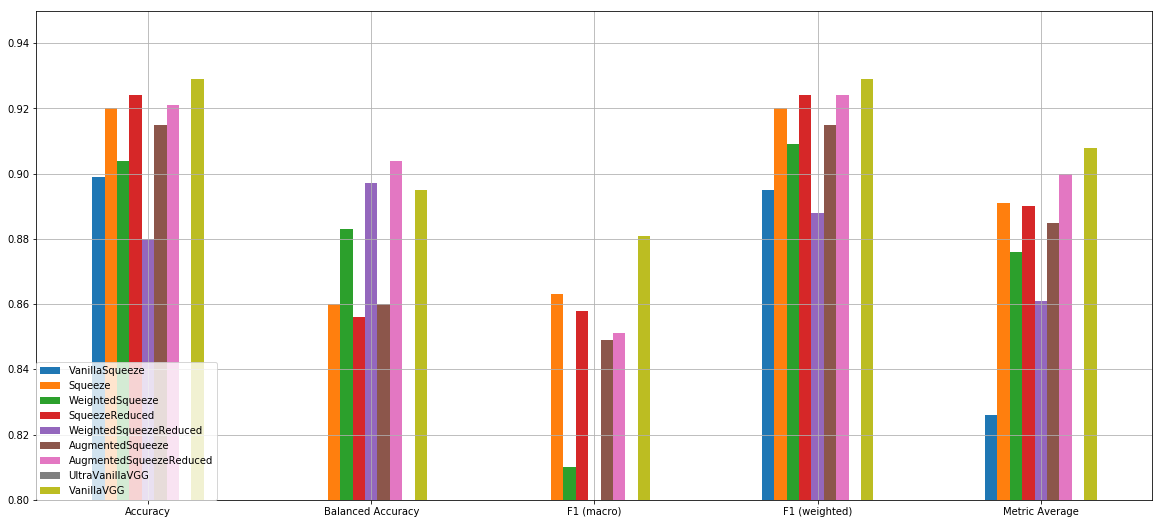

In [11]:
fig, ax = plt.subplots(1, 1, figsize = (20, 9))
df.iloc[1:, :-1].transpose().plot.bar(ax=ax)
ax.grid()
ax.set_ylim([0.80, 0.95])
ax.tick_params(axis='x', labelrotation = 0)
ax.legend(loc=[0, 0])
plt.show()

In [ ]:
fig = plt.figure(figsize = (15, 13))
#plt.title('Confusion Matrix')
for i in range(6):
    ax = fig.add_subplot(2, 3, i+1)
    cm = confusion_matrix(ys_pred[i], ys_true[i])
    cm_plot = ax.matshow(cm, cmap='Blues_r')
    ax.set_title(df.index[i])
    if i in [0, 3]:
        ax.set_ylabel('Predicted')
        ax.set_yticklabels(['No Defects', 'No Defects', 'Type 1', 'Type 2', 'Type 3', 'Type 4'])
    else:
        #plt.colorbar(cm_plot)
        ax.set_yticklabels([])
    ax.xaxis.set_ticks_position('bottom')
    ax.set_xticklabels(['No Defects', 'No Defects', 'Type 1', 'Type 2', 'Type 3', 'Type 4'])
    for i in range(N_CLASSES):
        for j in range(N_CLASSES):
            k = 0
            ax.text(j, i, cm[i, j], va='center', ha='center')

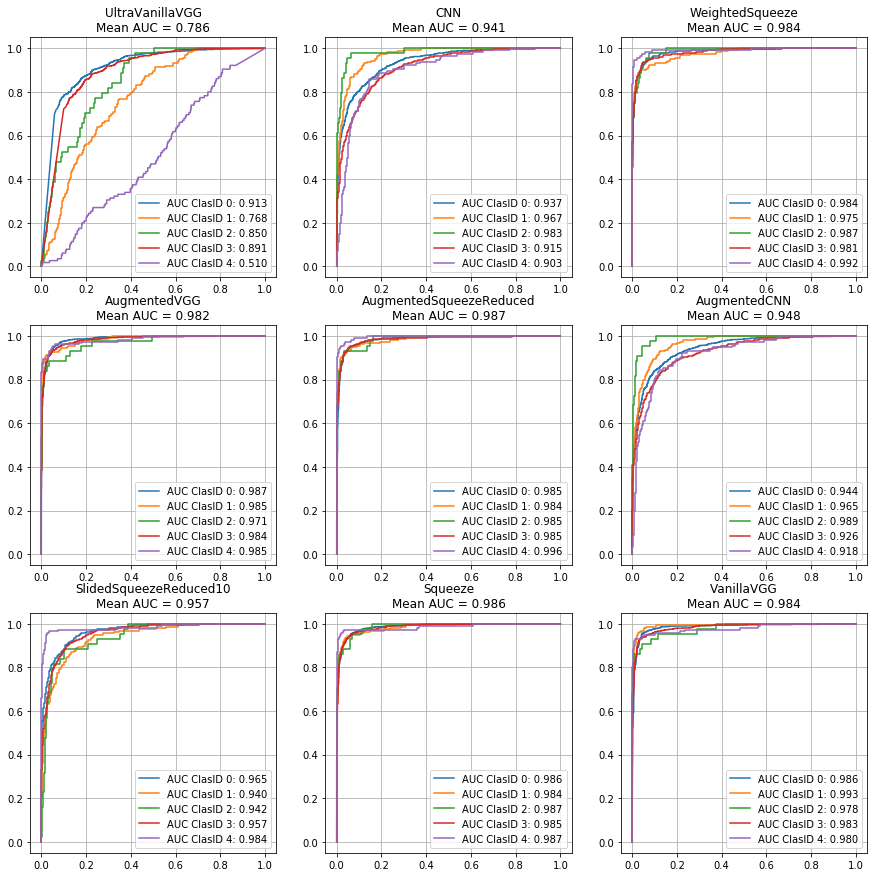

In [35]:
fig = plt.figure(figsize = (15, 15))
#plt.title('Confusion Matrix')
for j in range(1, N_MODEL):
    ax = fig.add_subplot(3, 3, j)
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(N_CLASSES):
        y_tmp = ys_true[j].copy()
        y_tmp[y_tmp != i] = N_CLASSES
        y_tmp[y_tmp == i] = N_CLASSES + 1
        y_tmp -= N_CLASSES

        fpr[i], tpr[i], _ = roc_curve(y_tmp, ys_score[j][:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        ax.plot(fpr[i], tpr[i], label='AUC ClasID {}: {:.3f}'.format(i, roc_auc[i]))
        ax.grid()
        ax.set_title('{}\nMean AUC = {:.3f}'.format(df.index[j], np.mean(list(roc_auc.values()))))
        ax.legend()